## Quick Start

In [ ]:
%matplotlib inline 
from pycotools import model, viz, tasks, misc
import os
import pandas
import seaborn
seaborn.set_style('white')
seaborn.set_context('notebook')

### Create Michaelis-Menten Model

In [15]:
working_directory = r'/home/b3053674/Documents/Models/2018/01_Jan/PyCoToolsQuickStart'
copasi_file = os.path.join(working_directory, 'quick_start_model.cps')

if os.path.isfile(copasi_file):
    os.remove(copasi_file)
    
antimony_string = """
model michaelis_menten()
    compartment cell = 1.0
    var E in cell
    var S in cell
    var ES in cell
    var P in cell

    kf = 0.1
    kb = 1
    kcat = 0.3
    E = 75
    S = 1000

    SBindE: S + E => ES; kf*S*E
    ESUnbind: ES => S + E; kb*ES
    ProdForm: ES => P + E; kcat*ES
end
"""

with model.BuildAntimony(copasi_file) as loader:
    michaelis_menten = loader.load(antimony_string)
    
    
michaelis_menten

Model(name=michaelis_menten, time_unit=s, volume_unit=l, quantity_unit=mol)

### Simulate Michaelis-Menten model

In [19]:
TC = tasks.TimeCourse(michaelis_menten, end=100, 
                      step_size=1, intervals=100, 
                      report_name='MM-time-course.csv')

### Plot results

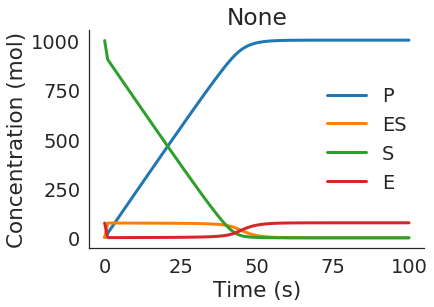

In [20]:
## all on one graph
viz.PlotTimeCourse(TC, separate=False)

plotting "P" on the x axis


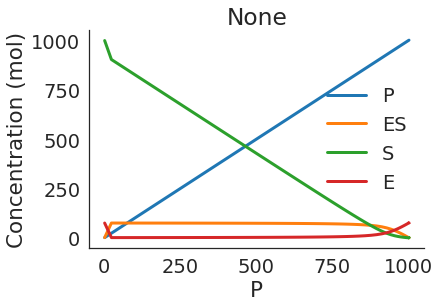

In [21]:
## Get metabolite names
metabolite_names = [i.name for i in michaelis_menten.metabolites]

## get the first in the list
metab = metabolite_names[0]

print('plotting "{}" on the x axis'.format(metab))

## plot in phase space by specifying x and y parameters
viz.PlotTimeCourse(TC, x=metab, separate=False)

### Inspect the model

In [22]:
print('model has {} metabolites, {} reactions and {} local parameters'.format(
    len(michaelis_menten.metabolites),
    len(michaelis_menten.reactions),
    len(michaelis_menten.local_parameters)
)
     )


model has 4 metabolites, 3 reactions and 0 local parameters


### Prepare Time Course Results for Parameter Estimation
Since copasi headers from copasi output looks like this:

In [23]:
pandas.read_csv(TC.report_name, sep='\t').head()## i.e. species names are enclosed in '[]'

,Time,[P],[ES],[S],[E],Values[kcat],Values[kb],Values[kf]
0,0,1.0000,1.0000,1000.000,75.00000,0.3,1,0.1
1,1,23.2535,74.9227,903.824,1.07735,0.3,1,0.1
2,2,45.7263,74.8956,881.378,1.10437,0.3,1,0.1
3,3,68.1907,74.8672,858.942,1.13277,0.3,1,0.1
4,4,90.6465,74.8373,836.516,1.16265,0.3,1,0.1


And we need exact match between variable names and data file headers, we can use the `misc.correct_copasi_timecourse_headers` function to automatically format the simulated time course data for us

In [24]:
## Note this overwrites the data file and returns a df. 
misc.correct_copasi_timecourse_headers(TC.report_name).head()

,Time,P,ES,S,E,kcat,kb,kf
0,0,1.0000,1.0000,1000.000,75.00000,0.3,1,0.1
1,1,23.2535,74.9227,903.824,1.07735,0.3,1,0.1
2,2,45.7263,74.8956,881.378,1.10437,0.3,1,0.1
3,3,68.1907,74.8672,858.942,1.13277,0.3,1,0.1
4,4,90.6465,74.8373,836.516,1.16265,0.3,1,0.1


### Do parameter estimations
Spread computation over multiple model copies. Use an appropriate `copy_number` for your computers capabilities. Monitor task manager or system monitor to see CopasiSE tasks in operation.

In [47]:
PE = tasks.MultiParameterEstimation(michaelis_menten, TC.report_name, method='genetic_algorithm_sr', 
                                   copy_number=3, pe_number=20, population_size=50, 
                                   number_of_generations=100, metabolites=[], overwrite_config_file=True, 
                                   run_mode='parallel')
PE.write_config_file()
PE.setup()
PE.run()

print('PE results will go to {}'.format(PE.results_directory))

pycotools.tasks:INFO:3740:    running model: 0
pycotools.tasks:INFO:3740:    running model: 1
pycotools.tasks:INFO:3740:    running model: 2
PE results will go to /home/b3053674/Documents/Models/2018/01_Jan/PyCoToolsQuickStart/MultipleParameterEstimationResults


### Visualize data

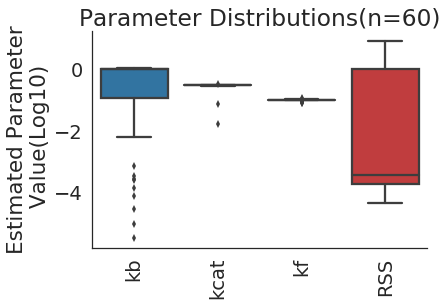

In [48]:
## boxplot all data
viz.Boxplots(PE, log10=True, num_per_plot=8)

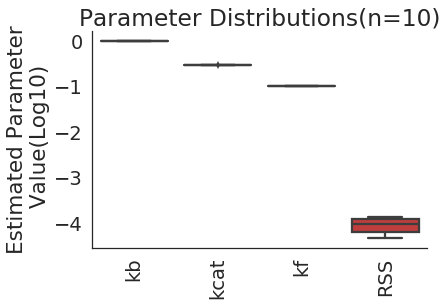

In [49]:
## box plot top 10 results
viz.Boxplots(PE, log10=True, num_per_plot=8, truncate_mode='ranks', theta=range(10))

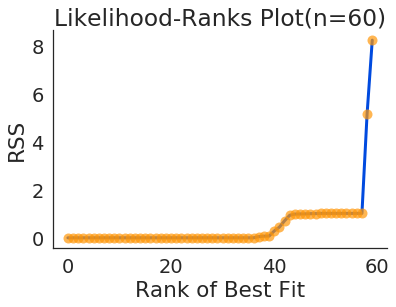

In [50]:
## Evaluate performance of optimization problem with likelihood-ranks plot
viz.LikelihoodRanks(PE, log10=False)

pycotools.viz:INFO:1540:    Plotting "E"
pycotools.viz:INFO:1540:    Plotting "S"
pycotools.viz:INFO:1540:    Plotting "ES"
pycotools.viz:INFO:1540:    Plotting "P"


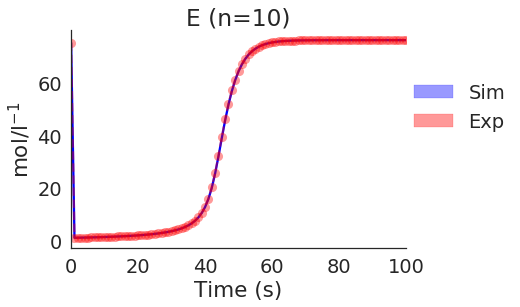

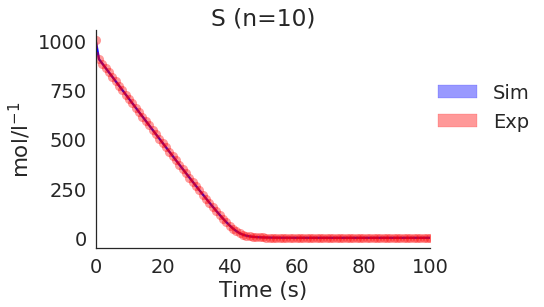

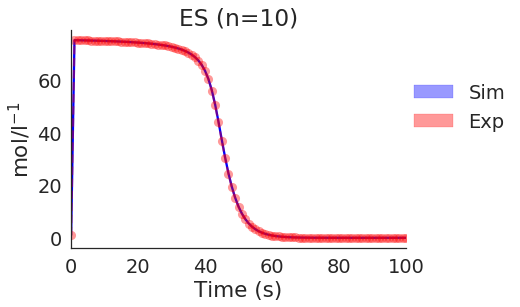

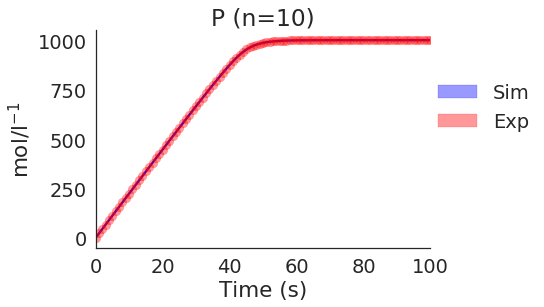

In [53]:
## visualize uncertainty in model predictions introduced by parameter sets
viz.PlotTimeCourseEnsemble(PE, truncate_mode='ranks', theta=range(10), y=['E', 'S', 'ES', 'P'])
## Note that the fits are quite good as a result of this being synthetic data

pycotools.viz:INFO:2621:    Plotting "kb" Vs "kf"


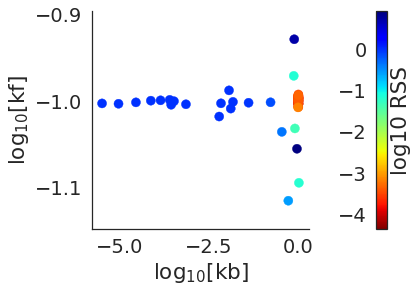

In [57]:
## Plot all combinations of parameter
viz.Scatters(PE, x=['kb'], y=['kf'], log10=True)

### Profile Likelihoods

In [58]:
PL = tasks.ProfileLikelihood(michaelis_menten, parameter_path=PE.results_directory, index=0, run=True,
                            max_active=4, number_of_steps=10, log10=True)

print(PL.results_directory)

pycotools.tasks:INFO:4930:    running /home/b3053674/Documents/Models/2018/01_Jan/PyCoToolsQuickStart/ProfileLikelihoods/0/kb.cps
pycotools.tasks:INFO:4930:    running /home/b3053674/Documents/Models/2018/01_Jan/PyCoToolsQuickStart/ProfileLikelihoods/0/kcat.cps
pycotools.tasks:INFO:4930:    running /home/b3053674/Documents/Models/2018/01_Jan/PyCoToolsQuickStart/ProfileLikelihoods/0/kf.cps
/home/b3053674/Documents/Models/2018/01_Jan/PyCoToolsQuickStart/ProfileLikelihoods


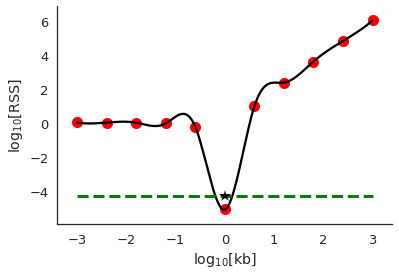

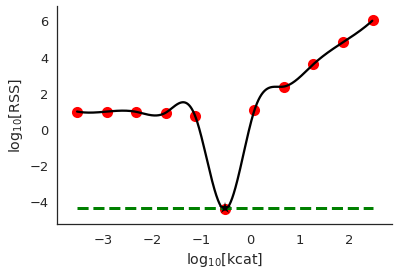

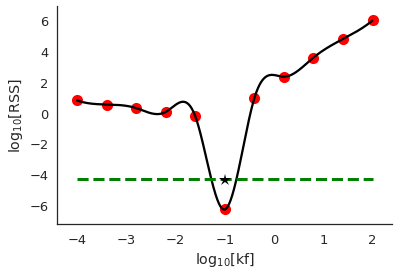

In [59]:
viz.PlotProfileLikelihood(PL, interpolation='cubic', log10=True)

### Best Parameters
Original Parameters:
    
    * kcat: 0.3
    * kf: 0.1
    * kb: 1


Best estimated parameters:

In [60]:
viz.Parse(PE).data.iloc[0]

kb      1.002770
kcat    0.299312
kf      0.100071
RSS     0.000046
Name: 0, dtype: float64